In [2]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from models_config.model_config_GSP import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
G_list = load_data(dataset, -1, NormalizeInputGraphs=False)

Using downloaded and verified file: /Users/lorenzostigliano/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/lorenzostigliano/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/lorenzostigliano/.medmnist/breastmnist.npz
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /Users/lorenzostigliano/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source im

In [3]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [4]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [5]:
def get_best_student_ensamble(model, view, CV, runs, dataset, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, _ = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return [best_rep_max, student_var[student_max], student_max], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]
    

In [6]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

In [6]:
analysis_type="model_assessment"
dataset_split="val"
dataset = "gender_data"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gcn_student_lsp_ensamble_4_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=CV,
            dataset=dataset,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_lsp_ensamble_4
[[0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2]]
[[0.968888888888889, 5.949074074074056e-05, 1], [0.9306944444444444, 0.0004889853395061724, 3], [0.968888888888889, 5.949074074074056e-05, 1], [0.968888888888889, 5.949074074074056e-05, 1], [0.968888888888889, 5.949074074074056e-05, 1]]
[[0.9649999999999999, 0.00012222222222222262, 2], [0.9143055555555557, 0.00022918595679012328, 1], [0.9649999999999999, 0.00012222222222222262, 2], [0.9649999999999999, 0.00012222222222222262, 2], [0.9649999999999999, 0.00012222222222222262, 2]]
[[0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1]]


In [8]:
analysis_type="model_assessment"
dataset_split="val"
dataset = "gender_data"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gcn_student_lsp_ensamble_4_args_1,
    gcn_student_lsp_ensamble_4_args_2,
    gcn_student_lsp_ensamble_4_args_3,
    gcn_student_lsp_ensamble_4_args_4
]

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model="gcn_student_lsp_ensamble_4_ablation", 
            view=view, 
            CV=CV,
            dataset=dataset,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_lsp_ensamble_4
[[0.9590277777777777, 0.0008345871913580261, 1], [0.9388888888888889, 0.0004918981481481483, 2], [0.9388888888888889, 0.0004918981481481483, 2], [0.9590277777777777, 0.0008345871913580261, 1], [0.9388888888888889, 0.0004918981481481483, 2]]
[[0.974027777777778, 0.0005069637345678996, 3], [0.974027777777778, 0.0005069637345678996, 3], [0.974027777777778, 0.0005069637345678996, 3], [0.974027777777778, 0.0005069637345678996, 3], [0.974027777777778, 0.0005069637345678996, 3]]
[[0.9561111111111111, 0.00022037037037037085, 2], [0.9561111111111111, 0.00022037037037037085, 2], [0.9561111111111111, 0.00022037037037037085, 2], [0.9561111111111111, 0.00022037037037037085, 2], [0.9561111111111111, 0.00022037037037037085, 2]]
[[0.9552777777777777, 0.00038958333333333336, 3], [0.9083333333333334, 0.0009459876543209866, 1], [0.9083333333333334, 0.0009459876543209866, 1], [0.9552777777777777, 0.00038958333333333336, 3], [0.9083333333333334, 0.0009459876543209866, 1]]
gcn_stu

In [21]:
df_best_student = np.array(all_model_best_student)
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df.shape

(25, 5)

In [22]:
df_best_student = np.array(all_model_best_student)
df_var = []
for i in range(4):
    df_var.append(df_best_student[:, i, :, 1].flatten())
df_var = pd.DataFrame(np.array(df_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var_rep = df_var.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df_var_rep.index = index_values
df_var_rep.shape

(25, 5)

In [23]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(5):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())

In [24]:
all_data_var = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_var)[:,view_index]
    #number of ensembles 
    for i in range(5):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_var.append(np.array(view_data).flatten())

In [25]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy.shape

(25, 5)

In [26]:
df_var = pd.DataFrame(np.array(all_data_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var = df_var.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_var) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_var) % 5]

# Assign the new index to the DataFrame
df_var.index = index_values
df_var.shape

(25, 5)

In [27]:
df_acuracy = df_acuracy.loc['weighted acc'].T
df_var = df_var.loc['weighted acc'].T
df_var = np.sqrt(df_var)

df_rep = df.loc['weighted acc'].T
df_var_rep = df_var_rep.loc['weighted acc'].T
df_var_rep = np.sqrt(df_var_rep)

In [28]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with the given data

# Define the new column labels
x_ticks = ['Original', 'No alpha', 'No beta', 'No gamma', 'No lambda']
# Rename the columns using the new labels
df_acuracy.columns = x_ticks
df_rep.columns = x_ticks
df_var.columns = x_ticks
df_var_rep.columns = x_ticks
# Display the modified DataFrame
df_var

,Original,No alpha,No beta,No gamma,No lambda
0,0.009602,0.018193,0.009789,0.001086,0.005550
1,0.004146,0.007972,0.004039,0.001177,0.003695
2,0.002405,0.010521,0.002384,0.002686,0.005132
3,0.003948,0.009723,0.004060,0.001354,0.001646
4,0.005718,0.012245,0.005794,0.001704,0.004287


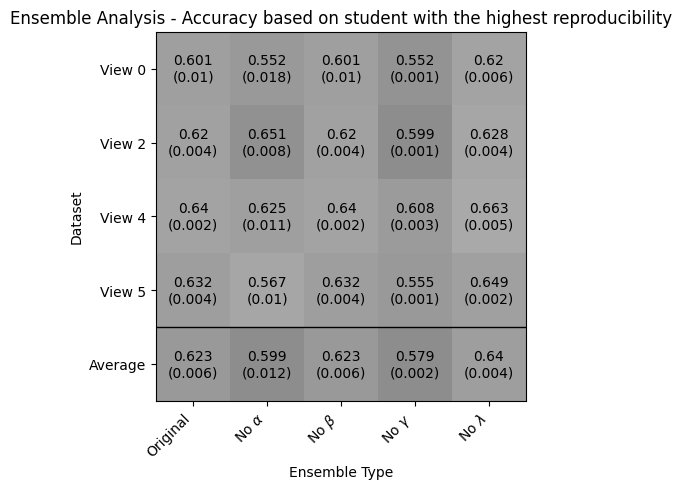

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
df_ordered = df_acuracy
df_std_ordered = df_var
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)
    
# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['Original', r'No $\alpha$', r'No $\beta$', r'No $\gamma$', r'No $\lambda$']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ablation Analysis - Accuracy based on student with weighted accuracy')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

plt.show()


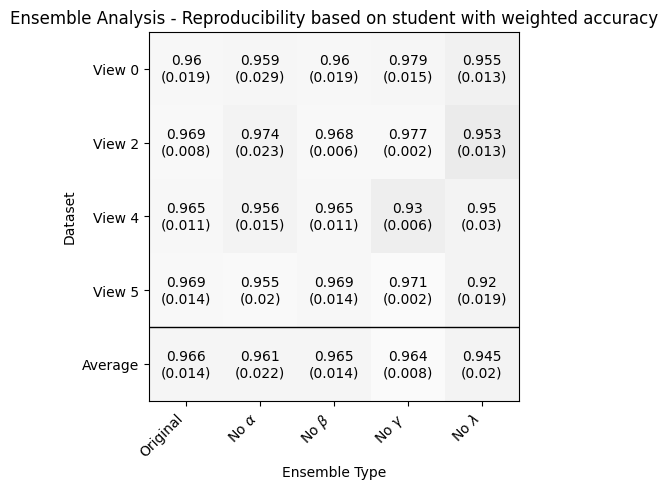

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
df_ordered = df_rep
df_std_ordered = df_var_rep
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['Original', r'No $\alpha$', r'No $\beta$', r'No $\gamma$', r'No $\lambda$']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ablation Study - Reproducibility based on student with weighted accuracy')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

plt.show()

## DISENTANGLEMENT LOSS

In [7]:

gcn_student_lsp_ensamble_4_args
gcn_student_lsp_ensamble_4_args_4

def extract_weights(dataset, view, model, run, student, model_args=None):
    weights = []
    for cv_n in range(3):
        weights.append(get_weight(dataset, view, model, "3Fold", 0, cv_n, run, student, model_args=model_args))
    for cv_n in range(5):
        weights.append(get_weight(dataset, view, model, "5Fold", 0, cv_n, run, student, model_args=model_args))
    for cv_n in range(10):
        weights.append(get_weight(dataset, view, model, "10Fold", 0, cv_n, run, student, model_args=model_args))
    
    return weights

In [8]:
dataset_split="val"
dataset = "gender_data"

dis = []
no_dis = []

for view in [0,2,4,5]:
    dis_view = []
    no_dis_view = []
    for student in [0,1,2,3]:
        dis_view.append(extract_weights(dataset=dataset, 
                        view=view, 
                        model=gcn_student_lsp_ensamble_4_args["model_name"], 
                        run=0, 
                        student=student, 
                        model_args=gcn_student_lsp_ensamble_4_args))

        no_dis_view.append(extract_weights(dataset=dataset, 
                        view=view, 
                        model="gcn_student_lsp_ensamble_4_ablation", 
                        run=0, 
                        student=student, 
                        model_args=gcn_student_lsp_ensamble_4_args_4))
    dis.append(dis_view)
    no_dis.append(no_dis_view)


In [9]:
dis_0 = sum(dis[1], [])
no_dis_0 = sum(no_dis[1], [])

/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/lorenzostigliano/Documents/University/Imperial/env-test/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


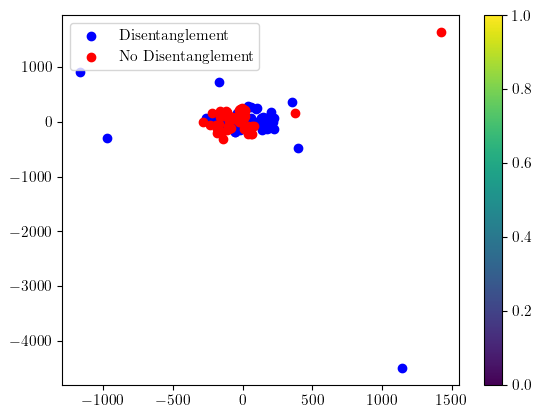

: 

In [210]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

perplexity = [2]

for per in perplexity:
    tsne = TSNE(n_components=2, perplexity=per, random_state=2)
    tsne_data = tsne.fit_transform(dis_0 + no_dis_0)

    # Split the data into two halves
    half_point = len(tsne_data) // 2
    first_half = tsne_data[:half_point]
    second_half = tsne_data[half_point:]

    # Plot the first half in one color
    plt.scatter(first_half[:, 0], first_half[:, 1], c='blue', label='Disentanglement')

    # Plot the second half in another color
    plt.scatter(second_half[:, 0], second_half[:, 1], c='red', label='No Disentanglement')

    plt.colorbar()
    plt.legend()
    plt.show()

# TESTING EMBEDDINGS OF DIFFERENT ABLATION METHODS

In [71]:
import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from models.model_config import *

import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)

/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_15845/2726708896.py:16: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


In [129]:
model_1_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn_student_lsp_ensamble_4_ablation/models/MainModel_10Fold_gender_data_gcn_student_lsp_ensamble_4_run_0_fixed_init_student_0_CV_0_view_5_alpha_0_beta_2_gamma_2_lambda_1.pt'
model_2_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn_student_lsp_ensamble_4_ablation/models/MainModel_10Fold_gender_data_gcn_student_lsp_ensamble_4_run_0_fixed_init_student_0_CV_0_view_5_alpha_1_beta_0_gamma_2_lambda_1.pt'
model_3_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn_student_lsp_ensamble_4_ablation/models/MainModel_10Fold_gender_data_gcn_student_lsp_ensamble_4_run_0_fixed_init_student_0_CV_0_view_5_alpha_1_beta_2_gamma_0_lambda_1.pt'
model_4_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn_student_lsp_ensamble_4_ablation/models/MainModel_10Fold_gender_data_gcn_student_lsp_ensamble_4_run_0_fixed_init_student_0_CV_0_view_5_alpha_1_beta_2_gamma_2_lambda_0.pt'
model_5_dir = '/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/model_data/gender_data/gcn/model_assessment/gcn_student_lsp_ensamble_4/models/MainModel_10Fold_gender_data_gcn_student_lsp_ensamble_4_run_0_fixed_init_student_0_CV_0_view_5_alpha_1_beta_2_gamma_2_lambda_1.pt'

model_layer_1 = torch.load(model_1_dir)
model_layer_2 = torch.load(model_2_dir)
model_layer_3 = torch.load(model_3_dir)
model_layer_4 = torch.load(model_4_dir)
model_layer_all = torch.load(model_5_dir)

In [130]:
import time
from torch.autograd import Variable

def embeddings(model):
    
    model.eval()
    
    G_list = load_data("gender_data", 0, NormalizeInputGraphs=False)

    folds = stratify_splits(G_list, 3)

    graph_embeddings = []
        
    [random.shuffle(folds[i]) for i in range(len(folds))]
    train_set, validation_set, test_set = datasets_splits(folds, gcn_student_lsp_ensamble_4_args, 0)
    train_dataset, val_dataset, threshold_value = model_assessment_split(train_set, validation_set, test_set, gcn_student_args)

    for batch_idx, data in enumerate(train_dataset):

        adj = Variable(data['adj'].float(), requires_grad=False).to(device)
        adj = torch.squeeze(adj)

        label = Variable(data['label'].long()).to(device)     

        features = np.identity(adj.shape[0])
        features = Variable(torch.from_numpy(features).float(), requires_grad=False).to("cpu")
        if gcn_student_args["threshold"] in ["median", "mean"]:
            adj = torch.where(adj > threshold_value, torch.tensor([1.0]).to("cpu"), torch.tensor([0.0]).to("cpu"))

        begin_time = time.time()

        x, _ = model(features, adj)
        graph_embeddings.append((x[0].tolist(), label.item()))

    return graph_embeddings

In [131]:
coordinates_1 = embeddings(model_layer_1)
coordinates_2 = embeddings(model_layer_2)
coordinates_3 = embeddings(model_layer_3)
coordinates_4 = embeddings(model_layer_4)
coordinates_all = embeddings(model_layer_all)

Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232
Num training graphs:  466 ; Num test graphs:  232


In [132]:
from sklearn.metrics import silhouette_score

for coordinates in [coordinates_all, coordinates_1, coordinates_2, coordinates_3, coordinates_4]:
    silhouette_avg = silhouette_score([i[0] for i in coordinates], [i[1] for i in coordinates])
    print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.006784417257436967
Silhouette Score: 0.004070682346810087
Silhouette Score: 0.006721917356054343
Silhouette Score: 0.003818904402307048
Silhouette Score: 0.019069115459932007
